# Generic LA tool

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from src.dlla.hw import dlla_p_gradient, prepare_traces_dl
from src.dlla.model9 import make_model_9
from src.dlla.wegener import make_mlp_wegener, wegener_p_gradient
from src.pollution.tools import file_suffix
from src.tools.cache import cache_np
from src.tools.lists import randomize
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT, store_sns, TVLA_PALETTE, DLLA_PALETTE
from src.trace_set.database import Database
from src.trace_set.set_hw import TraceSetHW
from src.tvla.cri import tvla_cri, make_t_test_kernel, rho_test_kernel
from src.tvla.tvla import prune, ASCAD_DEAD_TRACES

from src.trace_set.transform import reduce_fixed_fixed, fixed_fixed

init_plots()

In [76]:
DB = Database.aisy

TRACES_NAME = ""
if DB is Database.aisy:
    TRACES_NAME = "AISy lab traces"
elif DB is Database.ascad_none:
    TRACES_NAME = "ASCAD unprotected traces"
elif DB is Database.ascad:
    TRACES_NAME = "ASCAD masked traces"

TRACE_SET = TraceSetHW(DB)

POLLUTION_TYPE = None
FILE_SUFFIX = file_suffix(POLLUTION_TYPE, 0)

NUM_CLASSES = 9

In [77]:
REPEAT_DLLA = 30 # 30
REPEAT_TVLA = 100

In [78]:
PROF_X, PROF_Y = TRACE_SET.profile()

Computing Central Moments: 100%|██████████| 6/6 [00:00<00:00, 22.42it/s]


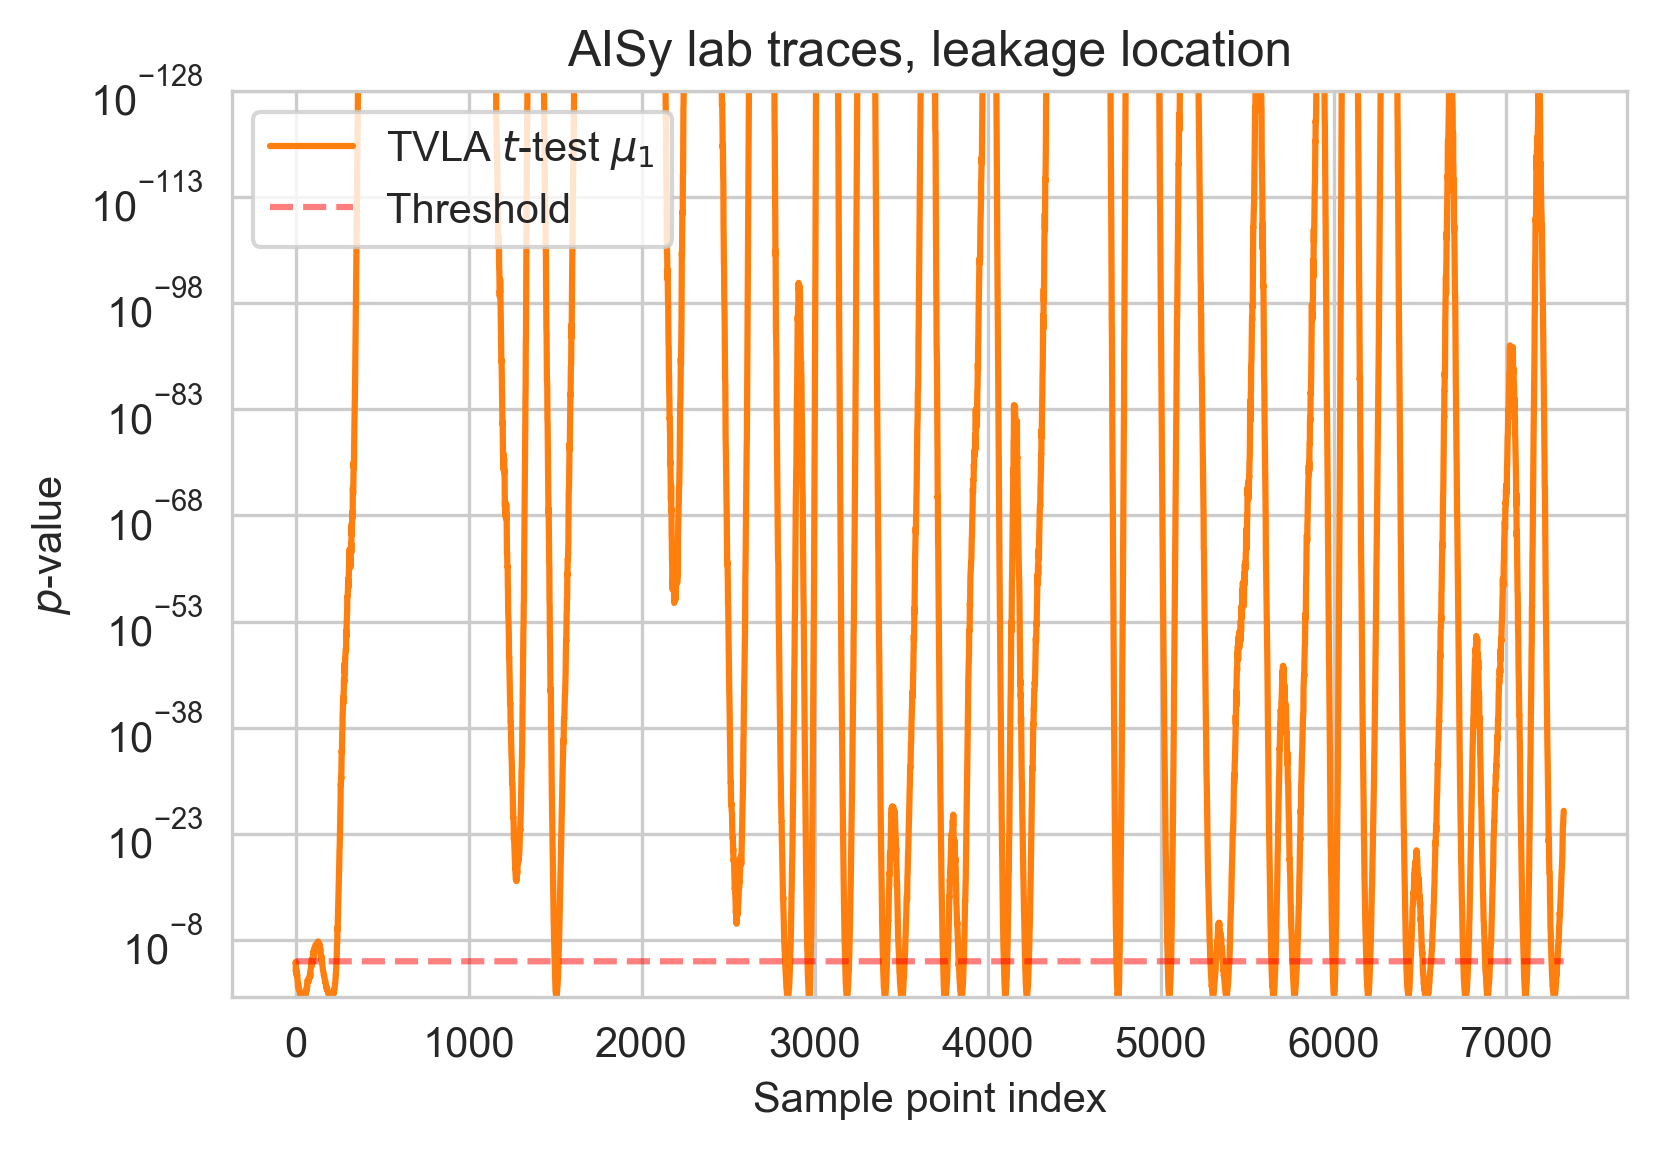

In [79]:
PVS_T = tvla_cri(PROF_X, PROF_Y, progress=True)

ORDER = 1

G = sns.lineplot(data={"TVLA $t$-test $\mu_1$": PVS_T[ORDER]}, palette=[TVLA_PALETTE[-1]])
sns.lineplot(data= [10 ** -5] * len(PVS_T[ORDER]), color="#FF000080", linestyle="--", label="Threshold")
G.invert_yaxis()
G.set(yscale="log", ylabel="$p$-value", xlabel="Sample point index", title=f"{TRACES_NAME}, leakage location", ylim=(10 ** 0, 10 ** -128))
store_sns(G, f"{DB.name}-pvs-t-{FILE_SUFFIX}")

In [ ]:
PVS_RHO = tvla_cri(PROF_X, PROF_Y, kernel=rho_test_kernel, progress=True)

G = sns.lineplot(data={"TVLA $\\rho$-test": PVS_RHO[0]}, palette=[TVLA_PALETTE[-1]])
sns.lineplot(data= [10 ** -5] * len(PVS_RHO[0]), color="#FF000080", linestyle="--", label="Threshold")
G.invert_yaxis()
G.set(yscale="log", ylabel="$p$-value", xlabel="Sample point index", title=f"{TRACES_NAME}, leakage location", ylim=(10 ** 0, 10 ** -128))
store_sns(G, f"{DB.name}-pvs-rho-{FILE_SUFFIX}")

In [81]:
# WINDOW = (None, None)
# if DB is Database.aisy:
#     WINDOW = (0, 300)
# elif DB is Database.ascad_none:
#     WINDOW = (1150, 1450)
# elif DB is Database.ascad:
#     WINDOW = (0, 1400)
#
# PROF_X = PROF_X[:, WINDOW[0]:WINDOW[1]]
# PVS_T = PVS_T_ALL[:, WINDOW[0]: WINDOW[1]]
# PVS_RHO = PVS_RHO_ALL[:, WINDOW[0]: WINDOW[1]]

np.min(PVS_T), np.argmin(PVS_RHO)

(0.0, 1922)

In [82]:
WINDOW_SIZE = PROF_X.shape[1]
TITLE_SUB = f"{TRACES_NAME} with {WINDOW_SIZE} sample points"

In [83]:
def single_tvla_t_pg(x, y, min_pvs, order):
    min_sp = min_pvs.argmin()

    num_traces = len(x)
    num_points = 300
    start = 2

    x_lim = np.array(x[:, min_sp:min_sp + 1])
    x_lim, y = prune(x_lim, y, ASCAD_DEAD_TRACES)

    pvs = np.ones(num_points)

    point_ixs = np.linspace(start, num_traces, num_points).astype(int)

    kernel = make_t_test_kernel(order)
    for ix, limit in enumerate(point_ixs):
        pvs[ix] = np.min(tvla_cri(x_lim[:limit], y[:limit], kernel, progress=False)[order])

    return np.interp(np.arange(num_traces), point_ixs, pvs)

def tvla_t_p_gradient(x, y, min_pvs, order, times=REPEAT_TVLA):
    res = []
    for _ in tqdm(range(times), "TVLA t-test p-gradient"):
        res.append(single_tvla_t_pg(x, y, min_pvs, order))

    return np.median(res, axis=0)

TVLA_PG_T_1 = cache_np(f"{DB.name}-tvla-t-1", tvla_t_p_gradient, PROF_X, PROF_Y, PVS_T[1], 1)
TVLA_PG_T_2 = cache_np(f"{DB.name}-tvla-t-2", tvla_t_p_gradient, PROF_X, PROF_Y, PVS_T[2], 2)
TVLA_PG_T_3 = cache_np(f"{DB.name}-tvla-t-3", tvla_t_p_gradient, PROF_X, PROF_Y, PVS_T[3], 3)

TVLA t-test p-gradient:   0%|          | 0/100 [00:00<?, ?it/s]


IndexError: index 68602 is out of bounds for axis 0 with size 6667

In [ ]:
def single_tvla_rho_pg(x, y, min_pvs):
    min_sp = min_pvs.argmin()

    num_traces = len(x)
    num_points = 600
    start = 2

    x_lim = np.array(x[:, min_sp - 2:min_sp + 2])
    x_lim, y = prune(x_lim, y, ASCAD_DEAD_TRACES)

    pvs = np.ones(num_points)

    point_ixs = np.linspace(start, num_traces, num_points).astype(int)

    for ix, limit in enumerate(point_ixs):
        pvs[ix] = np.min(tvla_cri(x_lim[:limit], y[:limit], rho_test_kernel, progress=False))

    pvs = np.nan_to_num(pvs, nan=1.)

    return np.interp(np.arange(num_traces), point_ixs, pvs)

def tvla_t_rho_gradient(x, y, min_pvs, times=REPEAT_TVLA):
    res = []
    for _ in tqdm(range(times), "TVLA rho p-gradient"):
        res.append(single_tvla_rho_pg(x, y, min_pvs))

    return np.median(res, axis=0)

TVLA_PG_RHO = cache_np(f"{DB.name}_tvla_rho", tvla_t_rho_gradient, PROF_X, PROF_Y, PVS_RHO)

TVLA_PG_RHO

In [ ]:
G = sns.lineplot(data={"$\\rho$-test": TVLA_PG_RHO, "$t$-test, $\mu_1$": TVLA_PG_T_1, "$t$-test, $\mu_2$": TVLA_PG_T_2, "$t$-test, $\mu_3$": TVLA_PG_T_3}, palette=np.array(TVLA_PALETTE)[[4, 3, 2, 1]])
sns.lineplot(data=[10 ** -5] * len(TVLA_PG_T_1), color="#FF000080", linestyle="--", label="Threshold")

G.set(yscale='log', xlabel="Number of traces", ylabel="$p$-value") #, xlim=(94314,94320))
G.invert_yaxis()
store_sns(G, f"{DB.name}-tvla")

In [ ]:
X, Y, X_ATT, Y_ATT = prepare_traces_dl(PROF_X, PROF_Y, *TRACE_SET.attack())

Y_RAND, Y_ATT_RAND = Y.copy(), Y_ATT.copy()
np.random.shuffle(Y_RAND), np.random.shuffle(Y_ATT_RAND)

In [ ]:
def make_dlla9_p_gradient(x9, y9, x9_att, y9_att, trials=REPEAT_DLLA):
    p_gradient = []

    for _ in tqdm(range(trials)):
        model_9 = make_model_9(x9, y9, x9_att, y9_att, False)
        pg = dlla_p_gradient(model_9, x9_att, y9_att)

        p_gradient.append(pg)

    return np.mean(p_gradient, axis=0)

PG_DLLA_9 = cache_np(f"{DB.name}_dlla9_pg", make_dlla9_p_gradient, X, Y, X_ATT, Y_ATT)
PG_DLLA_9_RANDOM = cache_np(f"{DB.name}_dlla9_pg_random", make_dlla9_p_gradient, X, Y_RAND, X_ATT, Y_ATT_RAND)

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_9),
    "FP check": np.array(PG_DLLA_9_RANDOM),
}, f"DL-LA performance validation (9-class)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
)

In [ ]:
def shuffle(x, y):
    ix = np.arange(len(x))
    np.random.shuffle(ix)

    return x[ix], y[ix]

def make_wegener_p_gradient(x, y, x_att, y_att, trials=REPEAT_DLLA):
    p_gradient = []

    x2, y2 = reduce_fixed_fixed(x, y)
    x2_att, y2_att = reduce_fixed_fixed(x_att, y_att)

    for _ in tqdm(range(trials)):
        x2, y2 = shuffle(x2, y2)
        x2_att, y2_att = shuffle(x2_att, y2_att)

        model_wegener = make_mlp_wegener(x2, y2, False)
        pg = wegener_p_gradient(model_wegener, x2_att, y2_att)

        p_gradient.append(pg)

    return np.mean(p_gradient, axis=0)

PG_DLLA_2_AB = cache_np(f"{DB.name}_dlla2_pg", make_wegener_p_gradient, X, Y, X_ATT, Y_ATT)
PG_DLLA_2_RANDOM = cache_np(f"{DB.name}_dlla2_pg_random", make_wegener_p_gradient, X, Y_RAND, X_ATT, Y_ATT_RAND)

plot_p_gradient({
    "A vs. B": np.array(PG_DLLA_2_AB),
    "FP check": np.array(PG_DLLA_2_RANDOM),
}, f"DL-LA performance validation (Wegener)\n{TITLE_SUB}",
    palette=PALETTE_GRADIENT,
)

In [ ]:
if POLLUTION_TYPE is None:
    TVLA_PGS = {
        "TVLA $\mu_1$": np.array(TVLA_PG_T_1),
        "TVLA $\mu_2$": np.array(TVLA_PG_T_2),
        "TVLA $\mu_3$": np.array(TVLA_PG_T_3),
    }

    plot_p_gradient(TVLA_PGS, f"TVLA $t$-test, different moment orders\n{TITLE_SUB}", palette=PALETTE_GRADIENT, file_name=f"{DB.name}-tvla-orders")

In [ ]:
MAX_TRACE_SIZE = max(len(PG_DLLA_9), len(PG_DLLA_2_AB), len(TVLA_PG_T_1))

COLOR_PALETTE = [DLLA_PALETTE[4], DLLA_PALETTE[2], TVLA_PALETTE[4], TVLA_PALETTE[2]]

def expand(arr, max_len=MAX_TRACE_SIZE):
    return np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=np.nan)

PGS = {
    "DL-LA 9-class": expand(PG_DLLA_9),
    "DL-LA Wegener": expand(PG_DLLA_2_AB),
    "TVLA $t$-test, $\mu_1$": expand(TVLA_PG_T_1),
    "TVLA $t$-test, $\mu_2$": expand(TVLA_PG_T_2),
}

plot_p_gradient(PGS, f"Method performance comparison\n{TITLE_SUB}", file_name=f"{DB.name}-all{FILE_SUFFIX}", palette=COLOR_PALETTE)

DF = pd.DataFrame(PGS)
DF.to_csv(f"{DB.name}-p-gradients{FILE_SUFFIX}.csv")

In [ ]:
plot_p_gradient(PGS, f"Method performance comparison\n{TITLE_SUB}", file_name=f"{DB.name}-all{FILE_SUFFIX}-1000", palette=COLOR_PALETTE, max_traces=1000)

In [ ]:
# PROF_Y_RANDOM = PROF_Y.copy()
# np.random.shuffle(PROF_Y_RANDOM)
#
# PGS_RANDOM_2 = cri_p_gradient(PROF_X, PROF_Y_RANDOM, tvla_cri(PROF_X, PROF_Y_RANDOM), 2)

In [ ]:
# if POLLUTION_TYPE is None:
#     plot_p_gradient({
#         "A vs. B": CRI_PG_2,
#         "Random": PGS_RANDOM_2,
#     }, f"TVLA performance validation ($t$-test for $\\mu_2$)\n{TITLE_SUB}",
#         palette=PALETTE_GRADIENT,
#         file_name=f"{DB.name}-tvla-validation-mu2")